# **Using a Physics-Informed Neural Network (PINN) to Solve an Ordinary Differential Equation**

In this notebook, we will demonstrate how to use a Physics-Informed Neural Network (PINN) to solve a differential equation. The illustration problem is to model the concentration of salt in a reservoir over time, taken from the book "**Problems In Mathematical Analysis**", by Demidovich.

## **Problem statement:**

We have a tank initially filled with 100 liters of water containing 10 kilograms of salt. Fresh water flows into the tank at a rate of 3 liters per minute, while the well-stirred mixture flows out at 2 liters per minute. The concentration of salt is assumed to remain uniform at all times due to perfect mixing.

**Question:** Determine the amount of salt in the tank after one hour.

## **Analytical Solution:**

- Initial Volume : $V(0) = 100L$ 

- Initial Mass of Salt: $x(0) = 10kg$

- Inflow Rate of Pure Water : $q_{in} = 3L/min$

- Outflow Rate of Mixture : $q_{out} = 2L/min$

- Input Concentration: $0$, (because of pure water)

- The volume of water in the tank changes over time as:
$$
V(t) = 100 + t, \qquad \text{since } 3\,\mathrm{L/min} \text{ in} - 2\,\mathrm{L/min} \text{ out} = +1\,\mathrm{L/min} \text{ net}
$$

Let $x(t)$ be the amount of salt (in kilograms) in the tank at time $t$ minutes.

- The rate of salt leaving is:

$$Outflow\_rate = 2\cdot\frac{x(t)}{V(t)}$$

The rate of change of Salt is given by:

$$
\frac{dx}{dt} = input\_salt - output\_salt
$$

Therefore,
$$
\frac{dx}{dt} = -\frac{2x(t)}{100 + V(t)}
$$

This is a separable first-order ODE. Integrating:
$$
lnx = −2ln(100+t) + lnC \Rightarrow x(t) = \frac{C}{(100+t)^2}
$$

Using the initial condition $x(0)=10$:
$$
10 = \frac{C}{100^2} \Rightarrow C = 10×100^2 = 100000
$$

Therefore, the exact solution is:
$$
x(t) = \frac{100000}{(100+t)^2}
$$

After one hour (i.e., $t = 60 minutes$):
$$
x(60) = \frac{100000}{(100 + 60)^2} = \frac{100000}{25600} \approx 3.90625 kg
$$

## **PINN Formulation:**

We can train a PINN to approximate $x(t)$ by enforcing that the function $x_{\theta }(t)$ (approximated by the network) satisfies:

- ODE:
  
$$
\Re _{\theta }(t) = \frac{dx_{\theta}(t)}{dt} + \frac{2x_{\theta}(t)}{100 + t} = 0
$$

- Initial Condition:
$$x_{\theta}(0) = 10$$

- Loss Function:

$$
Loss = \frac{1}{N}\sum_{i=1}^{N}|\Re _{\theta}(t_i)|^2 + \lambda∣x_{\theta}(0) − 10∣^2
\text{where } \lambda \text{ is a hyperparameter (weight of the Initial Condition).}
$$

### **Step 1: Define the PINN Model Using TensorFlow's Functional API**

First, we define the structure of our neural network. We use TensorFlow’s functional API to create the model. It takes a single input, the time variable t, and outputs a prediction for the amount of salt x in the reservoir.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float64')

In [3]:
inputs = tf.keras.Input(shape=(1,))
x = tf.keras.layers.Dense(64, activation='tanh')(inputs)
x = tf.keras.layers.Dense(32, activation='tanh')(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

I0000 00:00:1746913196.996660    8313 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6156 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


### **Step 2: Define the Residual of the Differential Equation (ODE)**

To solve the differential equation, we need to compute its residual. This is where the PINN’s power comes in. We use TensorFlow’s GradientTape to compute the derivative of $x(t)$ with respect to time, $\frac{dx}{dt}$, and subtract it from the left-hand side of the differential equation.

The equation we are solving is:
$$
\frac{dx}{dt} = -\frac{2x}{100 + t}
$$

In [4]:
def compute_residual(t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        x_pred = model(t)
    dx_dt = tape.gradient(x_pred, t)
    residual = dx_dt + 2 * x_pred / (100 + t)
    return residual

- $dx__dt$ is the predicted derivative of $x(t)$, calculated using GradientTape.

- residual is the difference between the left-hand side of the differential equation and the model’s prediction.


### **Step 3: Define the Total Loss Function**

The total loss function consists of two parts:

1. The residual loss from the differential equation, which ensures the model satisfies the ODE.

2. The initial condition loss, which enforces the fact that at $t=0$, the amount of salt in the reservoir is 10 kg.

In [5]:
def loss_fn(t_interior):
    # Residual ODE
    res = compute_residual(t_interior)
    loss_res = tf.reduce_mean(tf.square(res))

    # initial Condition : x(0) = 10
    x0 = model(tf.constant([[0.0]], dtype=tf.float64))
    loss_ic = tf.square(x0 - 10.0)

    return loss_res + loss_ic

- loss_res is the mean squared residual of the differential equation.

- loss_ic ensures that the initial condition x(0)=10x(0)=10 is satisfied.

### **Step 4: Train the PINN Model**

Next, we set up the optimizer and define a training step to minimize the total loss. We use the Adam optimizer with a learning rate of 0.001.

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

@tf.function
def train_step(t_interior):
    with tf.GradientTape() as tape:
        loss = loss_fn(t_interior)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

t_train = tf.random.uniform((500, 1), minval=0.0, maxval=60.0, dtype=tf.float64)
for epoch in range(10000):
    loss = train_step(t_train)
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy().item():.6f}")

Epoch 0, Loss: 100.010723
Epoch 500, Loss: 0.000279
Epoch 1000, Loss: 0.000162
Epoch 1500, Loss: 0.000079
Epoch 2000, Loss: 0.000045
Epoch 2500, Loss: 0.000036
Epoch 3000, Loss: 0.000031
Epoch 3500, Loss: 0.000027
Epoch 4000, Loss: 0.000024
Epoch 4500, Loss: 0.000021
Epoch 5000, Loss: 0.000018
Epoch 5500, Loss: 0.000016
Epoch 6000, Loss: 0.000015
Epoch 6500, Loss: 0.000013
Epoch 7000, Loss: 0.000012
Epoch 7500, Loss: 0.000011
Epoch 8000, Loss: 0.000011
Epoch 8500, Loss: 0.000010
Epoch 9000, Loss: 0.000009
Epoch 9500, Loss: 0.000009


### **Step 5: Evaluate the Model**

Once the model is trained, we evaluate it on a test set of time values between 0 and 60 minutes. We then use the trained model to predict the amount of salt in the reservoir over time.

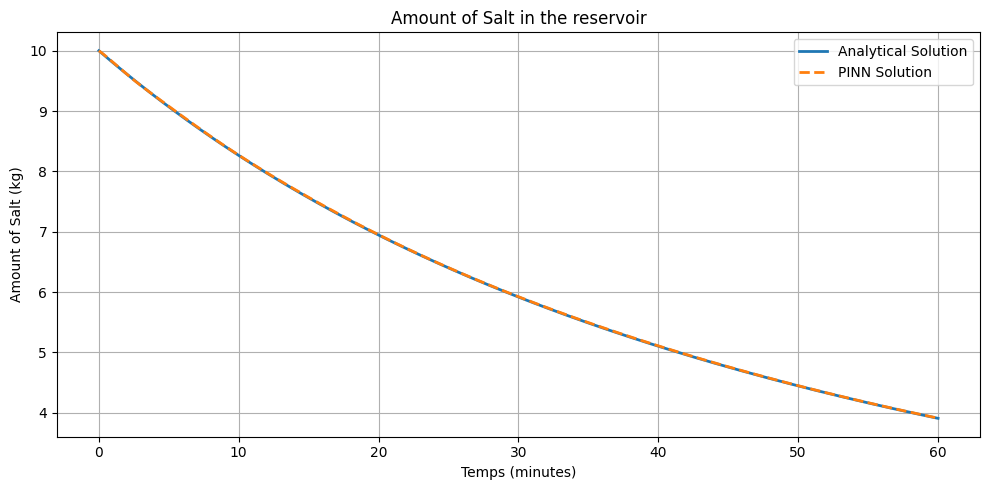

In [10]:
t_test = np.linspace(0, 60, 200).reshape(-1, 1)
t_test_tf = tf.convert_to_tensor(t_test, dtype=tf.float64)
x_pred = model(t_test_tf).numpy()

# Analytical Solution : x(t) = 10 * 100^2 / (100 + t)^2
x_exact = (10 * 100**2) / (100 + t_test) ** 2

# Plotting exact vs PINN solutions
plt.figure(figsize=(10, 5))
plt.plot(t_test, x_exact, label='Analytical Solution', linewidth=2)
plt.plot(t_test, x_pred, '--', label='PINN Solution', linewidth=2)
plt.xlabel('Temps (minutes)')
plt.ylabel('Amount of Salt (kg)')
plt.title('Amount of Salt in the reservoir')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# 9. Evaluation at t = 60 minutes (1 hour)
t_one_hour = np.array([[60.0]])  # t = 60 minutes
t_one_hour_tf = tf.convert_to_tensor(t_one_hour, dtype=tf.float64)
x_one_hour_pred = model(t_one_hour_tf).numpy()

print(f"Predicted amount of salt at t = 60 minutes: {x_one_hour_pred[0][0]:.6f} kg")

Predicted amount of salt at t = 60 minutes: 3.909632 kg


## **Conclusion**

In this notebook, we have demonstrated how to solve an ordinary differential equation (ODE) for salt concentration in a reservoir using a **Physics-Informed Neural Network (PINN)**. The model successfully approximates the analytical solution, showing the power of PINNs in solving real-world problems where traditional methods might be difficult or impossible to apply.

This method can be extended to more complex systems with more challenging differential equations, making it a versatile tool for scientists and engineers working with physical systems.